# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import time

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [2]:
model_name = "mono_1024x320"
# model_name = "mono_640x192"

# download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False).cuda()
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4)).cuda()

loaded_dict_enc = torch.load(encoder_path)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

depth_decoder.load_state_dict(torch.load(depth_decoder_path))

encoder.eval()
depth_decoder.eval()

pose_encoder_path = os.path.join("models", model_name, "pose_encoder.pth")
pose_decoder_path = os.path.join("models", model_name, "pose.pth")

pose_encoder = networks.ResnetEncoder(18, False, 2).cuda()
pose_encoder.load_state_dict(torch.load(pose_encoder_path))

pose_decoder = networks.PoseDecoder(pose_encoder.num_ch_enc, 1, 2).cuda()
pose_decoder.load_state_dict(torch.load(pose_decoder_path))

pose_encoder.eval()
pose_decoder.eval();

## Loading the test image and preprocessing

In [3]:
# image_path1 = '/home/ubuntu/hdd/data/BDD100K/images/100k/train/0a0c3694-24b5193a.jpg'
base_dir = '/home/ubuntu/hdd/data/kitti/RawData/2011_09_29/2011_09_29_drive_0071_sync'
image_path1 = os.path.join(base_dir, 'image_02/data/0000000330.png')
image_path2 = os.path.join(base_dir, 'image_02/data/0000000331.png')

input_image1 = pil.open(image_path1).convert('RGB')
input_image2 = pil.open(image_path2).convert('RGB')
original_width, original_height = input_image1.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image1_resized = input_image1.resize((feed_width, feed_height), pil.LANCZOS)
input_image2_resized = input_image2.resize((feed_width, feed_height), pil.LANCZOS)

input_image1_pytorch = transforms.ToTensor()(input_image1_resized).unsqueeze(0).cuda()
input_image2_pytorch = transforms.ToTensor()(input_image2_resized).unsqueeze(0).cuda()

## Prediction using the PyTorch model

In [24]:
t = time.time()
with torch.no_grad():
    features = encoder(torch.cat([input_image1_pytorch, input_image2_pytorch], 0))
    outputs = depth_decoder(features)
    disp1 = outputs[("disp", 0)][0]
    disp2 = outputs[("disp", 0)][1]
    features_pose = [pose_encoder(torch.cat([input_image1_pytorch, input_image2_pytorch], 1))]
    axisangle, translation = pose_decoder(features_pose)
    torch.cuda.synchronize()
print(time.time()-t)

0.021599531173706055


## Plotting

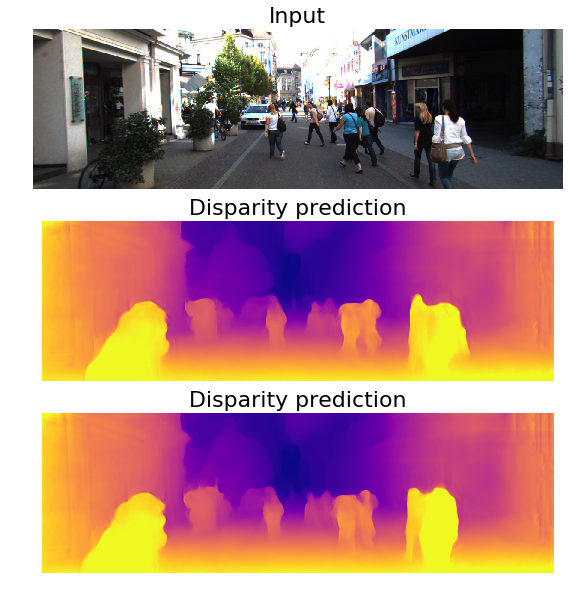

In [25]:
# disp_resized = torch.nn.functional.interpolate(disp,
#     (original_height, original_width), mode="bilinear", align_corners=False)

disp1_np = disp1.squeeze().cpu().numpy()
disp2_np = disp2.squeeze().cpu().numpy()
depth1_np = 5.4/disp1_np
vmax = np.percentile(disp1_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(311)
plt.imshow(input_image1)
plt.title("Input", fontsize=22)
plt.axis('off');

plt.subplot(312)
plt.imshow(disp1_np, cmap='plasma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

plt.subplot(313)
plt.imshow(disp2_np, cmap='plasma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');
# plt.subplot(313)
# plt.imshow(depth_np, cmap='jet', vmax=100)
# plt.title("Depth prediction", fontsize=22)
# plt.axis('off');

In [26]:
import yaml
from layers import *
with open('/home/ubuntu/hdd/data/kitti/RawData/2011_09_29/calib_cam_to_cam.txt', 'r') as f:
    calib_cam = yaml.load(f)
    
K = np.fromstring(calib_cam['P_rect_02'], dtype=np.float32, sep=' ').reshape(3, 4)
K[:, -1] = 0
K = np.concatenate([K, np.array([0, 0, 0, 1]).reshape(1, 4)], axis=0)
K[0] *= feed_width/original_width
K[1] *= feed_height/original_height

K_inv = np.linalg.inv(K)

In [27]:
disp1_, depth1 = disp_to_depth(disp1, 0.1, 100)
disp2_, depth2 = disp_to_depth(disp2, 0.1, 100)
backproject_depth = BackprojectDepth(1, feed_height, feed_width).cuda()
project_3d = Project3D(1, feed_height, feed_width).cuda()

t = time.time()
cam_points = backproject_depth(depth2, torch.FloatTensor(K_inv[np.newaxis,:]).cuda())
T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], True)
pix_coords = project_3d(cam_points, torch.FloatTensor(K[np.newaxis,:]).cuda(), T)

with torch.no_grad():
    img_warped12 = F.grid_sample(input_image1_pytorch, pix_coords, padding_mode="zeros")
    
cam_points = backproject_depth(depth1, torch.FloatTensor(K_inv[np.newaxis,:]).cuda())
T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], False)
pix_coords = project_3d(cam_points, torch.FloatTensor(K[np.newaxis,:]).cuda(), T)

with torch.no_grad():
    img_warped21 = F.grid_sample(input_image2_pytorch, pix_coords, padding_mode="zeros")
    
print(T)
torch.cuda.synchronize()
print(time.time()-t)

tensor([[[ 9.9999e-01, -3.4293e-04, -4.2959e-03,  2.1185e-04],
         [ 3.4066e-04,  1.0000e+00, -5.3055e-04, -4.4543e-05],
         [ 4.2961e-03,  5.2908e-04,  9.9999e-01, -3.0585e-03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')
0.0068511962890625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


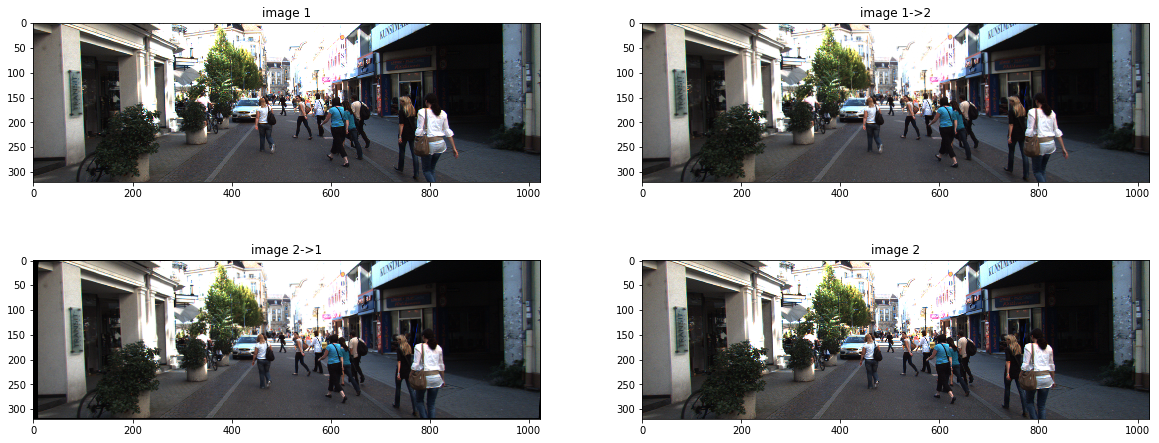

In [28]:
plt.figure(figsize=(20, 8))
plt.subplot(221)
plt.title('image 1')
plt.imshow(input_image1_pytorch.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(222)
plt.title('image 1->2')
plt.imshow(img_warped12.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(223)
plt.title('image 2->1')
plt.imshow(img_warped21.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(224)
plt.title('image 2')
plt.imshow(input_image2_pytorch.cpu().numpy()[0].transpose(1, 2, 0))